<a href="https://colab.research.google.com/github/Cesarszabo/Analise_dados_Python/blob/main/ScriptTCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: buscar ações da petrobras por dia de 2020 a 2023
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
# Importando a base de dados do Yahoo Finance
petrobras = yf.Ticker('PETR4.SA')

# Selecionando o período de treinamento
start_date = date(2021, 1, 1)
end_date = date(2022, 12, 31)
# Extraindo os dados do Yahoo Finance
df = petrobras.history(start=start_date, end=end_date)

# Selecionando o periodo de teste
start_date1 = date(2023, 1, 2)
end_date1 = date(2023, 12, 31)
# Extraindo os dados do Yahoo Finance
df1 = petrobras.history(start=start_date1, end=end_date1)

# Exibindo os dados

pregao_treino = pd.DataFrame({'Data': df.index.date, 'Preco_acao': df['Close']})
pregao_teste =  pd.DataFrame({'Data': df1.index.date, 'Preco_acao': df1['Close']})

# print(pregao_treino)
# print(pregao_teste)

In [ ]:
# prompt: gerar grafico do pregao
plt.plot(pregao_treino)
plt.xlabel("Data")
plt.ylabel("Preco_acao")
plt.title("Gráfico do Pregao da Petrobras de 2021 a 2023")
# plt.show()


###Modelagem ARIMA

In [ ]:
# prompt: resetar indice pregao_treino2

pregao_treino2 = pregao_treino.reset_index(drop=True)


In [ ]:
pregao_treino2 = pd.Series(pregao_treino['Preco_acao'])
pregao_treino3 = pregao_treino2.reset_index(drop=True)
# pregao_treino2.describe()
pregao_treino3.describe()

In [ ]:
pregao_treino3.shape

(497,)

Decomposição modelo Aditivo


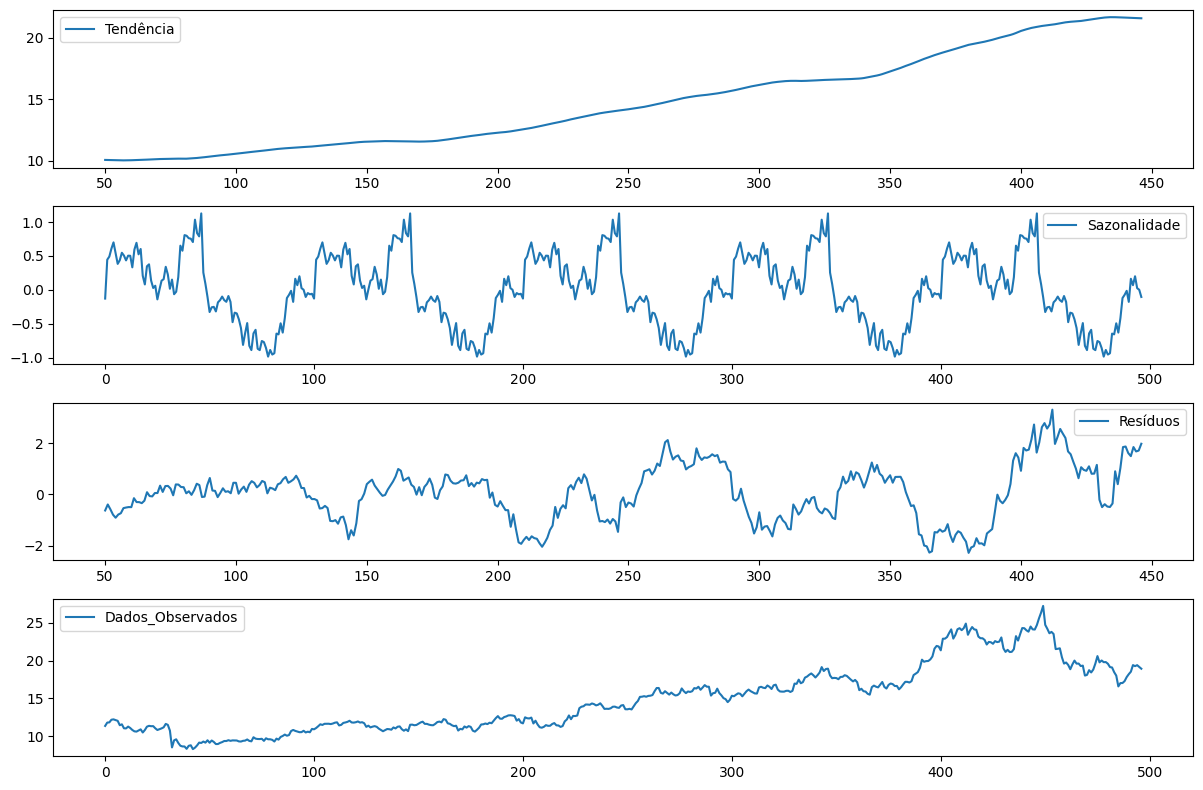

In [ ]:
# prompt: decompor serie pregao_treino

from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposição por modelo aditivo
result = seasonal_decompose(pregao_treino3, model = "additive", period=100)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
result.trend.plot(label='Tendência')
plt.legend(loc='best')

plt.subplot(412)
result.seasonal.plot(label='Sazonalidade')
plt.legend(loc='best')

plt.subplot(413)
result.resid.plot(label='Resíduos')
plt.legend(loc='best')

plt.subplot(414)
result.observed.plot(label='Dados_Observados')
plt.legend(loc='best')

plt.tight_layout()
print("Decomposição modelo Aditivo")
plt.show()


In [ ]:
# prompt: teste de dicker fuller serie pregao https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

# pregao = pd.Series(pregao)

from statsmodels.tsa.stattools import adfuller

# Calculate the Dickey-Fuller test statistic and p-value
testefuller = adfuller(pregao_treino3, maxlag= None, regression='c', autolag='AIC', store=False, regresults=False)

# print(type(testefuller))
# Print the results
print('''Teste Estátistico Dickey-Fuller :  {} \n p-values: {} \n observações: {} \n valores críticos {}

  Conclusão p-values 0,9891 > 0,05 portando rejeito a H0, a serie é não estacionaria  '''.format(testefuller[0], testefuller[1], testefuller[3], testefuller[4]))

Teste Estátistico Dickey-Fuller :  -1.02357504320576 
 p-values: 0.7445690355909396 
 observações: 496 
 valores críticos {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}

  Conclusão p-values 0,9891 > 0,05 portando rejeito a H0, a serie é não estacionaria  


In [ ]:
# prompt: função de autocorrelação de pregao

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

# Calculate the autocorrelation function
acf_values = acf(pregao_treino)

# Função
pacf_values = pacf(pregao_treino)

# Plot the autocorrelation function
plt.plot(acf_values)
plt.xlabel("Lag")
plt.ylabel("Autocorrelação")
plt.title("Função Autocorrelação dos valores de fechamento Petrobras 2021 a 2023")
plt.show()

# Plot the autocorrelation function
plt.plot(pacf_values)
plt.xlabel("Lag")
plt.ylabel("Autocorrelação Parcial")
plt.title("Função Autocorrelação Parcial dos valores de fechamento Petrobras 2021 a 2023")
plt.show()



In [ ]:
# modelo autoarima
# !pip install pmdarima
from pmdarima.arima import auto_arima

model = auto_arima(pregao_treino, information_criterion='aic')
print(model)
print(model.summary())

In [ ]:
forecast = model.predict(n_periods=360)
# print(forecast)

In [ ]:
# prompt: checar residuos de forecast

model.plot_diagnostics(figsize=(15, 8))
plt.show()


In [ ]:
# grafico interativo pregao_ previsao

from ipywidgets import interact
import plotly.graph_objects as go

# Create a figure with two traces: original data and predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=pregao_treino.index, y=pregao_treino, mode='lines', name='Dados Treinamento'))
fig.add_trace(go.Scatter(x=pregao_teste.index, y=pregao_teste, mode='lines', name='Dados Testes'))
fig.add_trace(go.Scatter(x=pregao_teste.index, y=forecast, mode='lines', name='Previsao'))


# Define a function to update the plot based on the selected date range
def update_plot(start_date, end_date):
    # Filter data based on the selected date range
    filtered_pregao = pregao[start_date:end_date]
    filtered_previsoes = previsoes[start_date:end_date]

    # Update traces with the filtered data
    fig.data[0].x = filtered_pregao.index
    fig.data[0].y = filtered_pregao
    fig.data[1].x = filtered_previsoes.index
    fig.data[1].y = filtered_previsoes

    # Update the plot layout
    fig.update_layout(
        xaxis_title='Data',
        yaxis_title='Preço de Fechamento',
        title='Previsão do Preço de Fechamento da Petrobras'
    )

# Create an interactive widget to select the date range
# interact(update_plot, start_date=pregao.index[0], end_date=pregao.index[-1])

# Display the interactive plot
fig.show()


Olhando para o grafico de tendendia e confirmado com o teste dicker-fuller a série não é estacionaria. Quando uma serie temporal não é estacionaria, para que as previsão seja mais acertiva, é necessario fazer a diferenciação. ou seja, numero - numero anterior

###Modelagem Multinivel

In [ ]:
import statsmodels.api as sm # biblioteca de modelagem estatística
from statsmodels.iolib.summary2 import summary_col
from skimage import io
import plotly.graph_objs as go
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
!pip install -q statstests
from statstests.process import stepwise
import seaborn as sns
import statsmodels.api as sm
from scipy import stats #estatística chi2

In [ ]:
!pip install python-BCB


In [ ]:
# Indicadores

from bcb import sgs

# 1639 - Índice de nacional de preços ao consumidor-Amplo (IPCA) - Transportes -
df2 = sgs.get({'IPCA': 1639}, start='2021-01-01', end="2023-01-01")
# df2.index = df2.index.to_period()
df2 = pd.DataFrame({'Data': df2.index.date, 'IPCA': df2['IPCA']})
# IPCA Teste
df6 = sgs.get({'IPCA': 1639}, start='2023-01-02', end="2023-12-31")
IPCA_teste = pd.DataFrame({'Data': df6.index.date, 'IPCA': df6['IPCA']})

# # 1391	Produção de derivados de petróleo - Total 	Barris/dia (mil)
df3 = sgs.get({'Petroleo': 1391}, start='2021-01-01', end="2023-01-01")
Barril_treino = pd.DataFrame({'Data': df3.index.date, 'Barril_Petroleo': df3['Petroleo']})
# BArril Teste
df5 = sgs.get({'Petroleo': 1391}, start='2023-01-02', end="2023-12-31")
Barril_teste = pd.DataFrame({'Data': df5.index.date, 'Barril_Petroleo': df5['Petroleo']})

# # 11	Taxa de juros - Selic	% a.d.
df4 = sgs.get({'SELIC':11}, start='2021-01-01', end="2023-01-01")
df4 = pd.DataFrame({'Data': df4.index.date, 'SELIC': df4['SELIC']})
# SELIC Test
df7 = sgs.get({'SELIC':11}, start='2023-01-02', end="2023-12-31")
SELIC_Teste = pd.DataFrame({'Data': df7.index.date, 'SELIC': df7['SELIC']})


In [ ]:
# Preparando o banco de treino
consolidado = pd.concat([pregao_treino, Barril_treino, df4, df2])

# tabela dinamica para a tabela consolidado

consolidado = pd.pivot_table(consolidado, values=['Preco_acao', 'Barril_Petroleo','SELIC','IPCA'], index=['Data'])

# substituir NaN no consolidado pelo seu antecessor  "pad" é uma abreviação para "padding", que em inglês significa "preenchimento"

consolidado = consolidado.fillna(method='pad')
consolidado = consolidado.dropna()
consolidado.describe()

In [ ]:
#### Consolidado Teste
consolidadoTeste = pd.concat([pregao_teste, Barril_teste, IPCA_teste, SELIC_Teste])
consolidadoTeste = pd.pivot_table(consolidadoTeste, values=['Preco_acao', 'Barril_Petroleo','SELIC','IPCA'], index=['Data'])
consolidadoTeste = consolidadoTeste.fillna(method='pad')
consolidadoTeste = consolidadoTeste.dropna()
consolidadoTeste.describe()

,Barril_Petroleo,IPCA,Preco_acao,SELIC
count,253.000000,253.000000,253.000000,253.000000
mean,3478.814229,0.583913,26.686944,0.049246
std,192.320895,0.751551,6.324225,0.002180
min,3193.000000,-0.570000,17.261333,0.043739
25%,3286.000000,0.270000,20.205183,0.047279
50%,3541.000000,0.370000,27.478144,0.050788
75%,3612.000000,1.400000,32.857841,0.050788
max,3760.000000,2.110000,37.360001,0.050788


In [ ]:
# prompt: exportar consolidado teste para excel

consolidadoTeste.to_excel("consolidadoTeste.xlsx")


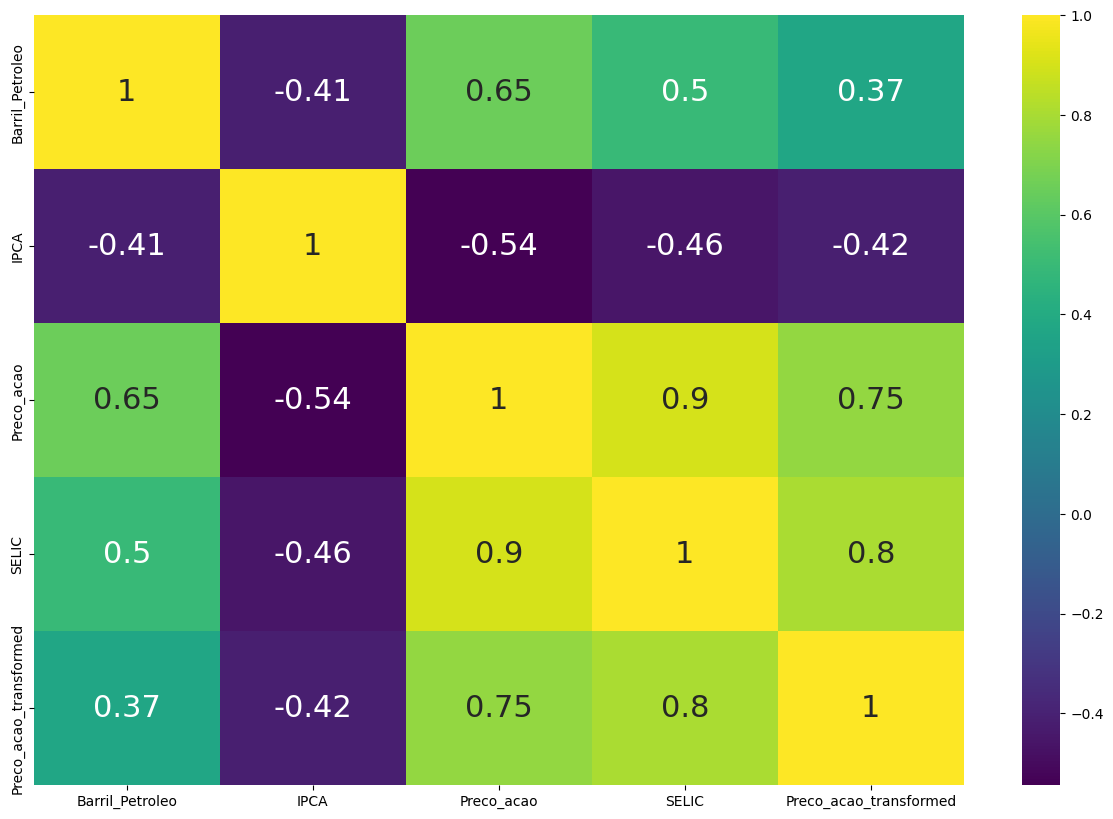

In [ ]:
# In[ ]: Matriz de correlações

corr = consolidado.corr()
corr

plt.figure(figsize=(15,10))
sns.heatmap(consolidado.corr(), annot=True, cmap = plt.cm.viridis,
            annot_kws={'size':22})
plt.show()



In [ ]:
# In[ ]: Distribuições das variáveis, scatters, valores das correlações e suas
#respectivas significâncias

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

plt.figure(figsize=(15,10))
graph = sns.pairplot(consolidado, diag_kind="kde")
graph.map(corrfunc)
plt.show()




In [ ]:
# In[ ]: Estimando um modelo múltiplo com as variáveis do dataset 'consolidado'

#Estimando a regressão múltipla
modelo_paises = sm.OLS.from_formula('Preco_acao ~ SELIC + Barril_Petroleo + IPCA', consolidado).fit()

#Parâmetros do modelo
modelo_paises.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Preco_acao   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1195.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          7.17e-229
Time:                        00:14:16   Log-Likelihood:                -939.94
No. Observations:                 509   AIC:                             1888.
Df Residuals:                     505   BIC:                             1905.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -20.6033      2.141     -9.622      0.000     -24.810     -16.397
SELIC             195.8277      5.118     38.261      0.000     185.772     205.883
Barril_Petroleo     0.0096      0.001     13.445      0.000       0.008       0.011
IPCA               -0.2504      0.042     -6.022      0.000      -0.332      -0.169
==============================================================================
Omnibus:                       22.019   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.880
Skew:                           0.528   Prob(JB):                     6.52e-06
Kurtosis:                       3.101   Cond. No.                     2.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# prompt: importar excel

import pandas as pd

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel('consolidadoTeste.xlsx')

# Print the DataFrame
print(df)


In [ ]:
#### importando banco com valores estimados

consolidadoFinal = pd.read_excel('/content/consolidado_final.xlsx')

In [ ]:

import plotly.graph_objects as go
import plotly.subplots as sp
# !pip install plotly.express
import plotly.express as px
# Create a figure with two traces: original data and predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=pregao_treino.index, y=pregao_treino, mode='lines', name='Dados Treinamento'))

fig = go.Figure()
# Add traces for each variable
fig.add_trace(go.Scatter(x=consolidadoFinal.Data, y=consolidadoFinal.Preco_acao, mode='lines', name='Preço Ação Real'))
fig.add_trace(go.Scatter(x=consolidadoFinal.Data, y=consolidadoFinal.Preco_Estimado, mode='lines', name='Preço Ação Estimado'))


# Show the plot
fig.show()
